In [1]:
import keras
import keras_tuner
import matplotlib.pyplot as plt

IMAGE_SIZE = (96, 96)
BATCH_SIZE = 32
TEST_SIZE = 0.4
VAL_SIZE = 0.2
DATA_DIR = "data"
ID_DRIVE = {
    "empty": "1NH3MTPqwPk25Zz127D6SP45dNnFkQB5e&confirm=t",
    "crossedout": "19_8vPdpYqO1WrM5gbchrRNDEXxjiIKLC&confirm=t",
    "confirmed": "1iQ8x12DvT7s15IUDegI87aJtcUMECXqU&confirm=t",
}
EPOCHS = 50
MAX_TRIALS = 10

2024-09-14 07:59:02.378209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 07:59:02.652290: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-14 07:59:02.723109: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-14 07:59:03.154482: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-14 07:59:04.858332: W tensorflow/compiler/tf2

In [2]:
tb_callback = keras.callbacks.TensorBoard(log_dir="./logs", histogram_freq=1)
el_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, start_from_epoch=5, verbose=1, restore_best_weights=True
)

In [3]:
import os
import pathlib
import tempfile
from functools import partial
from zipfile import ZipFile

import gdown
import numpy as np
import tensorflow as tf


def obtain_data(directory="data"):
    if os.path.exists(directory):
        print(f"O diretório {directory} já existe, pulando o download dos dados.")
        return

    with tempfile.TemporaryDirectory() as tmpdirname:
        print("created temporary directory", tmpdirname)
        for name, id in ID_DRIVE.items():
            gdown.download(id=id, output=os.path.join(tmpdirname, f"{name}.zip"))

        for file in os.listdir(tmpdirname):
            with ZipFile(os.path.join(tmpdirname, file), "r") as zip:
                zip.extractall(path=directory)


def get_label(file_path, class_names):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)


def decode_img(img, img_size):
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.image.resize(img, img_size)


def process_path(file_path, class_names, img_size):
    label = get_label(file_path, class_names)
    img = tf.io.read_file(file_path)
    img = decode_img(img, img_size)
    return img, label


def configure_for_performance(ds, batch_size):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds


def train_test_val_img_dataset(
    directory="data", seed=1337, test_size=0.2, val_size=0.2, batch_size=32, image_size=(224, 224)
):
    data_dir = pathlib.Path(directory).with_suffix("")

    list_ds = tf.data.Dataset.list_files(str(data_dir / "*/*"), shuffle=False)
    image_count = list_ds.cardinality().numpy()
    list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False, seed=seed)

    class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))

    train_ds = list_ds.skip(test_size * image_count + val_size * image_count)
    val_ds = list_ds.take(val_size * image_count)
    test_ds = list_ds.skip(val_size * image_count).take(test_size * image_count)

    process_path_p = partial(process_path, class_names=class_names, img_size=image_size)

    train_ds = train_ds.map(process_path_p, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(process_path_p, num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_ds.map(process_path_p, num_parallel_calls=tf.data.AUTOTUNE)

    train_ds = configure_for_performance(train_ds, batch_size)
    val_ds = configure_for_performance(val_ds, batch_size)
    test_ds = configure_for_performance(test_ds, batch_size)

    return train_ds, test_ds, val_ds, class_names


def count_labels(ds):
    label_counts = {}
    for _, labels in ds:
        labels_numpy = labels.numpy()

        for label_value in labels_numpy:
            label_value = int(label_value)
            if label_value in label_counts:
                label_counts[label_value] += 1
            else:
                label_counts[label_value] = 1
    return label_counts


def generate_class_weigths(class_counts):
    total_samples = sum(class_counts.values())
    class_weights = {}
    # Pesos para cada classe (inversamente proporcionais às frequências)
    for class_name, count in class_counts.items():
        class_weights[class_name] = total_samples / (len(class_counts) * count)

    return class_weights


## Carga dos dados

Os dados usados para a construção do modelo são do conjunto [MC Answer Boxes Dataset](https://sites.google.com/view/mcq-dataset), que contém diversos testes de múltipla escolha respondidos. Neste conjunto de dados, já temos as caixas de resposta de cada teste extraída e com a marcação entre "confirmada", "vazia" ou "cancelada".

Os dados estão disponíveis publicamente no Google Drive, e é possível fazer o download automático usando o pacote `gdown`.

Um diretório temporário é criado, os arquivos são baixados do Google Drive para este diretório e então são descompactados criando a pasta data.

Dentro da pasta data, são criados diretórios para cada classe ("confirmed", "empty" e "crossedout").


In [4]:
obtain_data(DATA_DIR)

created temporary directory /tmp/tmpyufr46q6


Downloading...
From: https://drive.google.com/uc?id=1NH3MTPqwPk25Zz127D6SP45dNnFkQB5e&confirm=t
To: /tmp/tmpyufr46q6/empty.zip
100%|██████████| 68.6M/68.6M [00:05<00:00, 11.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=19_8vPdpYqO1WrM5gbchrRNDEXxjiIKLC&confirm=t
To: /tmp/tmpyufr46q6/crossedout.zip
100%|██████████| 2.34M/2.34M [00:00<00:00, 5.81MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iQ8x12DvT7s15IUDegI87aJtcUMECXqU&confirm=t
To: /tmp/tmpyufr46q6/confirmed.zip
100%|██████████| 144M/144M [00:08<00:00, 16.3MB/s] 


## Leitura do dataset

Os dados serão divididos em três partes:

1. **Treino** : Dados que serão utilizados para treinar o modelo.
2. **Validação**: Dados que serão utilizados para avaliar o modelo durante o treinamento.
3. **Teste**: Dados que serão utilizados para avaliar o modelo após o treinamento.

A separação em validação e teste garante que a avaliação do modelo será feita com dados que não foram vistos em nenhum momento durante o treinamento - nem mesmo na validação.

O conjunto de teste é salvo para reutilização na obtenção de métricas e visualização de previsões.
Além disso, uma pequena quantidade de batches é salva para teste automatizado na API.

In [17]:
train_ds, test_ds, val_ds, class_names = train_test_val_img_dataset(
    DATA_DIR, test_size=TEST_SIZE, val_size=VAL_SIZE, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, seed=1337
)
test_ds.save("datasets/ds_test")
test_ds.shuffle(test_ds.cardinality()).take(50).save("datasets/ds_test_sample")
del test_ds

Os dados são referentes a imagens das caixas de resposta extraídas de testes de múltipla escolha. Cada imagem é de uma caixa de resposta, e a marcação da caixa é feita como "confirmed" (confirmada), "empty" (vazia) ou "crossedout" (cancelada).


2024-09-14 07:59:39.774450: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


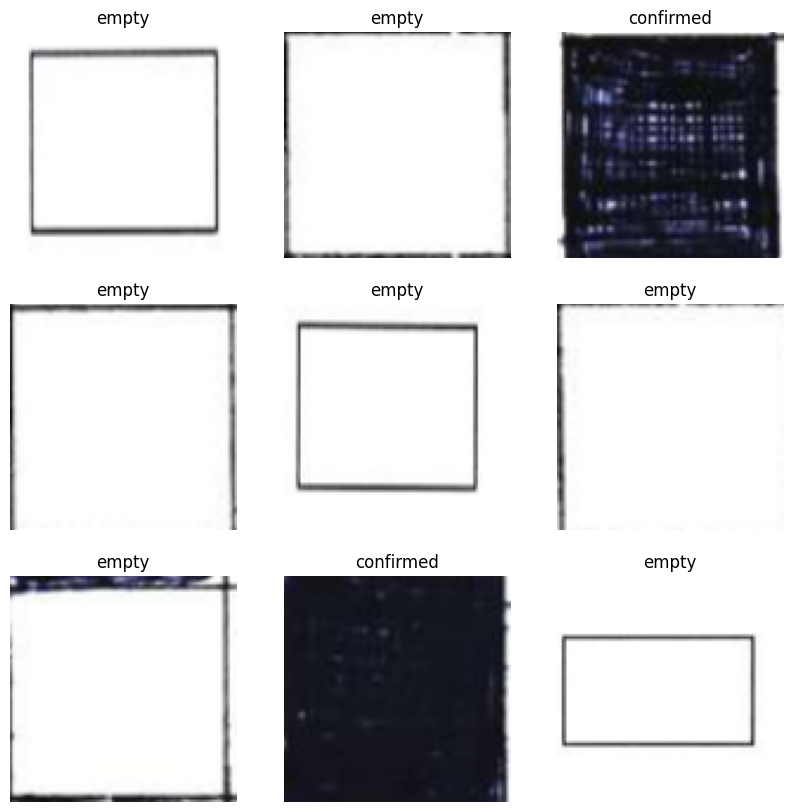

In [6]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

Geralmente, quando respondendo um teste de múltipla escolha, não é muito frequente as vezes em que cancelamos uma resposta. Portanto, é esperado que a classe "crossedout" possua uma frequência menor que as outras classes.

Além disso, testes múltiplas escolhas usualmente possuem mais do que duas alteranativas, com apenas uma delas sendo a alternativa correta. Portanto, também é esperado que a classe "empty" possua uma frequência menor que a classe "confirmed".

In [7]:
train_class_freq = count_labels(train_ds)

{class_names[k]: v for k, v in train_class_freq.items()}

2024-09-14 07:59:41.777773: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'confirmed': 4333, 'empty': 9000, 'crossedout': 87}

Para corrigir esse desbalanceamento, uma possível alternativa é aumentar o peso dessa classe durante o treinamento do modelo.

In [8]:
class_weights = generate_class_weigths(train_class_freq)
{class_names[k]: v for k, v in class_weights.items()}

{'confirmed': 1.0323871067005155,
 'empty': 0.49703703703703705,
 'crossedout': 51.417624521072796}

## Definição do modelo

O modelo utilizado é um modelo treinado usando trasnfer learning com o modelo Xception.

Foi incluído um passo de preprocessamento para ajustar o tamanho das imagens para o tamanho desejado pelo modelo.
Por mais que os conjuntos de dados usados no treino e no teste já estejam com o tamanho correto, no momento da previsão podem ser passadas imagens de qualquer tamanho que serão ajustadas para o tamanho correto.

Além disso, foi incluído um passo de normalização, que ajusta os valores para o intervalo [-1, 1].


In [9]:
def make_model(input_shape, num_classes, dropout, learning_rate):
    base_model = keras.applications.MobileNetV2(
        weights="imagenet",
        input_shape=input_shape + (3,),
        include_top=False,
    )
    base_model.trainable = False

    inputs = keras.Input(shape=[None, None, 3])
    # Step de preprocessamento para ajudar na previsão - isso me permite
    # usar imagens de qualquer tamanho na hora de realizar a previsão.
    naive_resize = keras.layers.Resizing(*input_shape)(inputs)

    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(naive_resize)
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)

    if dropout:
        x = keras.layers.Dropout(0.2)(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
        ],
    )
    return model

## Otimização dos hiperparâmetros

Foram escolhidos para otimização os seguintes hiperparâmetros:

1. **Learning rate**: Taxa de aprendizado do modelo.
2. **Dropout**: Utilização ou não de dropout.

A otimização é realizada utilizando uma busca aleatória no espaço de hiperparâmetros, com no máximo 5 tentativas.

In [10]:
def build_model(hp):
    input_shape = IMAGE_SIZE
    num_classes = len(class_names)
    dropout = hp.Boolean("dropout")
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")

    model = make_model(input_shape, num_classes, dropout, learning_rate)
    return model


tuner = keras_tuner.BayesianOptimization(
    build_model,
    objective="val_acc",
    max_trials=MAX_TRIALS,
    project_name="otimizacao_hiperparametros",
    seed=1337,
    # overwrite=True,
)
tuner.search_space_summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Search space summary
Default search space size: 2
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [11]:
tuner.search(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=[tb_callback, el_callback],
)

Trial 20 Complete [00h 02m 21s]
val_acc: 0.9935907125473022

Best val_acc So Far: 0.9956774711608887
Total elapsed time: 00h 49m 09s


Resumo da busca pelos melhores hiperparâmetros:

In [12]:
tuner.results_summary()

Results summary
Results in ./otimizacao_hiperparametros
Showing 10 best trials
Objective(name="val_acc", direction="max")

Trial 12 summary
Hyperparameters:
dropout: False
learning_rate: 0.0005302037084352516
Score: 0.9956774711608887

Trial 11 summary
Hyperparameters:
dropout: True
learning_rate: 0.0011783385953542033
Score: 0.9955283999443054

Trial 08 summary
Hyperparameters:
dropout: False
learning_rate: 0.004261929805333454
Score: 0.9952303171157837

Trial 06 summary
Hyperparameters:
dropout: False
learning_rate: 0.00046160080727729693
Score: 0.9950812458992004

Trial 07 summary
Hyperparameters:
dropout: False
learning_rate: 0.000492437162767469
Score: 0.9949321746826172

Trial 14 summary
Hyperparameters:
dropout: False
learning_rate: 0.0002130826968244784
Score: 0.9949321746826172

Trial 04 summary
Hyperparameters:
dropout: False
learning_rate: 0.000396478365712187
Score: 0.9946340918540955

Trial 17 summary
Hyperparameters:
dropout: False
learning_rate: 0.00537881367703449
Score

## Ajuste do modelo

Após obter a melhor combinação de hiperparâmetros, o modelo pode ser treinado novamente, com a melhor combinação dos hiperparâmetros.

In [ ]:
best_hps = tuner.get_best_hyperparameters(1)
model = build_model(best_hps[0])
model.summary(show_trainable=True)
del tuner, best_hps

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_3 (InputLayer)  │ (None, None, None, 3) │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ resizing_1 (Resizing)       │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling_1 (Rescaling)     │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mobilenetv2_1.00_96         │ (None, 3, 3, 1280)    │  2,257,984 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_1  │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 3)             │      3,843 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

O modelo é salvo a cada época através do callback ModelCheckpoint. Se a *validation loss* parar de diminuir, o treinamento é interrompido de forma antecipada através do callback EarlyStopping. Além disso, são salvos logs para visualização do treinamento no TensorBoard.

In [14]:
if not os.path.exists("models"):
    os.makedirs("models")

callbacks = [
    # keras.callbacks.ModelCheckpoint("models/checkpoint/save_at_{epoch}.keras"),
    el_callback,
    tb_callback,
]

model.fit(train_ds, epochs=EPOCHS, callbacks=callbacks, validation_data=val_ds, class_weight=class_weights)

Epoch 1/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - acc: 0.9066 - loss: 0.6974 - val_acc: 0.9498 - val_loss: 0.1570
Epoch 2/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - acc: 0.9619 - loss: 0.1565 - val_acc: 0.9781 - val_loss: 0.0711
Epoch 3/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - acc: 0.9789 - loss: 0.0897 - val_acc: 0.9675 - val_loss: 0.0983
Epoch 4/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - acc: 0.9823 - loss: 0.0691 - val_acc: 0.9897 - val_loss: 0.0364
Epoch 5/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - acc: 0.9887 - loss: 0.0562 - val_acc: 0.9875 - val_loss: 0.0429
Epoch 6/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - acc: 0.9892 - loss: 0.0414 - val_acc: 0.9918 - val_loss: 0.0278
Epoch 7/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - acc: 0.9934 - loss: 0.0338 - val_acc: 0.9899 - val_loss: 0.0332
Epoch 8/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - acc: 0.9935 - loss: 0.0283 - val_acc: 0.9921 - val_loss: 0.0266
Epoch 9/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms

O modelo treinado é salvo para uso posterior pela API.

In [15]:
model.save("models/omr_model.keras")

O notebook `metrics.ipynb` apresenta o resultado da avaliação do modelo treinado no conjunto de teste, assim como algumas conclusões. 